https://ir.nctu.edu.tw/bitstream/11536/50742/1/352801.pdf

In [107]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
from pickle import dump
from pickle import load
import joblib
import re
import sweetviz as sv
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance 
final_date = '2021-04-11'
target_ToolGID = 'PK_DUVKrF'
# target_ToolGID = 'XE_Sorter'
# target_ToolGID = 'MA_Alps'
# target_ToolGID = 'PW_PIX'
 
target_prodID ='C11MD01A'
datafile ='./data/prodkpi/prodkpi_POC_0411_PK_DUVKrF.csv'

In [55]:
# plt.rcParams["figure.figsize"] = (5,3)

In [56]:
def iqrfilter(df, colname, bounds = [.25, .75]):
    s = df[colname]
    Q1 = df[colname].quantile(bounds[0])
    Q3 = df[colname].quantile(bounds[1])
    IQR = Q3 - Q1
    # print(IQR,Q1,Q3,Q1 - 1.5*IQR,Q3+ 1.5 * IQR)
    if bounds[0]==0:
        return df[~s.clip(*[Q1,Q3+ 1.5 * IQR]).isin([Q1,Q3+ 1.5 * IQR])]
    else:
        return df[~s.clip(*[Q1 - 1.5*IQR,Q3+ 1.5 * IQR]).isin([Q1 - 1.5*IQR,Q3+ 1.5 * IQR])]

In [57]:

def build_model(hp):
    
    # from tensorflow.keras import layers
    from kerastuner.tuners import RandomSearch
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

# 繪製模型預測圖

In [58]:
def drawModelResult(modelType,TOOLG_ID,x,y_actual,y_predict28 ,imagepath):

    plt.figure(figsize=(8, 5))# 设置图片尺寸
    plt.title('TOOLG_ID:'+ TOOLG_ID+ " ("+modelType+")")
    # t = np.arange(len(X_dropped))# 创建t变量
    plt.plot(x, y_actual, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    plt.plot(x, y_predict28, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    # plt.plot(x, y_predict_actrual, 'k', linewidth=1, marker='.', label='predict on actual') # 绘制predict曲线
    plt.legend()
        # target_ToolGID = 'PK_DUVKrF'
    # target_ToolGID = 'XE_Sorter'
    # target_ToolGID = 'MA_Alps'
    # target_ToolGID = 'PW_PIX'
    # if TOOLG_ID=='PK_DUVKrF' :
    #     plt.yticks(np.linspace(0.15,0.45,9))
    # elif TOOLG_ID=='XE_Sorter' :
    #     plt.yticks(np.linspace(0.0,0.12,9))
    # elif TOOLG_ID=='MA_Alps' :
    #     plt.yticks(np.linspace(0.0,0.5,9))
    # elif TOOLG_ID=='PW_PIX' :
    #     plt.yticks(np.linspace(0.0,0.1,9))    
    plt.savefig(imagepath)

## NN 模型

In [59]:
def tuningNN(load_model,x,y):
    #tf.keras.wrappers.scikit_learn.KerasClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score, precision_score, recall_score,r2_score
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
    # randcv = RandomizedSearchCV(estimator=MyNN(lr=0.005,nfirst=10,nhidden1=10,nhidden2=0,dropout=0.2,output_bias=0.1,batch_size=100,epochs=1),\
    #                             param_distributions=dict( epochs=[ 50,100,200], batch_size=[ 10,100],nhidden1=[2,5,10],nfirst=[10,20],dropout=[0.2],output_bias=[0.1,0.9],scale_pos_weight=[1,10]),\
    #                             n_iter=30, scoring='f1', n_jobs=1, cv=cv, verbose=1).fit(dftrain[xs], dftrain['y'])

    # pd.DataFrame(randcv.cv_results_).sort_values(by='mean_test_score',ascending=False)
    build_model = lambda: load_model
    Kmodel = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, verbose=1)
    scorers = {
        # 'precision_score': make_scorer(precision_score),
        # 'recall_score': make_scorer(recall_score),
        # 'accuracy_score': make_scorer(accuracy_score)
        'r2_score':make_scorer(r2_score)
        }
        #layers=[[8,16,20],  [45, 30, 15]],


#     distributions = {
# "n_hidden": [0, 1, 2, 3],
# "n_neurons": np.arange(1, 100).tolist(),
# "learning_rate": np.arange(3e-4, 3e-2).tolist()
# }

    distributions = dict(batch_size = [ 16,32,64,75], epochs = [50, 75,100] #  , optimizer=['rmsprop', 'adam']#hidden_layers=[[64], [32]]
    )
    #     batch_size = [10, 20, 40, 60, 80, 100]
#     epochs = [10, 50, 100]
    # activations = ['relu'], 
    # param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
    # grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, cv=5)


    clf = RandomizedSearchCV(Kmodel, distributions, scoring=scorers,random_state=0,n_iter = 5, cv = 2, verbose=10,refit='r2_score')

    from joblib import Parallel, delayed, parallel_backend
    with parallel_backend('threading',n_jobs=12):
        search = clf.fit(x, y)
    
    # print("RandomizedSearchCV took %.2f seconds for %d candidates"
    #       " parameter settings." % ((time() - start), n_iter_search))
    print(clf.best_estimator_.model) 
    # 評估，打分數
    print(f"最佳準確率: {clf.best_score_}，最佳參數組合：{clf.best_params_}")
    # 取得 cross validation 的平均準確率及標準差
    # means = clf.cv_results_['mean_test_score']
    # stds = clf.cv_results_['std_test_score']
    # params = clf.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print(f"平均準確率: {mean}, 標準差: {stdev}, 參數組合: {param}")
    # print(clf.cv_results_)

    # {'mean_fit_time': array([ 9.92220247, 11.41317749,  8.51325178,  5.53384042,  6.71829283]), 
    # 'std_fit_time': array([0.15850294, 0.2024827 , 0.09449553, 0.07199621, 0.11651003]), 
    # 'mean_score_time': array([0.39148962, 0.26898944, 1.17896593, 0.75547612, 0.40098655]), 
    # 'std_score_time': array([0.09949863, 0.17497933, 0.10899651, 0.0884949 , 0.03799713]), 
    # 'param_epochs': masked_array(data=[100, 100, 50, 30, 30],
    #          mask=[False, False, False, False, False],
    #    fill_value='?',
    #         dtype=object), 'param_batch_size': masked_array(data=[64, 32, 32, 64, 32],
    #          mask=[False, False, False, False, False],
    #    fill_value='?',
    #         dtype=object), 'params': [{'epochs': 100, 'batch_size': 64}, {'epochs': 100, 'batch_size': 32}, {'epochs': 50, 'batch_size': 32}, {'epochs': 30, 'batch_size': 64}, {'epochs': 30, 'batch_size': 32}], 'split0_test_r2_score': array([-1.42770799, -1.4276857 , -1.4277966 , -1.42778419, -1.42786533]), 'split1_test_r2_score': array([-1.87841303, -1.87841303, -1.87872848, -1.87892689, -1.87892689]), 'mean_test_r2_score': array([-1.65306051, -1.65304937, -1.65326254, -1.65335554, -1.65339611]), 'std_test_r2_score': array([0.22535252, 0.22536367, 0.22546594, 0.22557135, 0.22553078]), 'rank_test_r2_score': array([2, 1, 3, 4, 5])}
 

    return clf.best_estimator_.model

In [60]:
# def tunningNN(create_model,X,Y):
    
#     model = KerasClassifier(build_fn=create_model, verbose=0)
#     # define the grid search parameters
#     batch_size = [10, 20, 40, 60, 80, 100]
#     epochs = [10, 50, 100]
#     param_grid = dict(batch_size=batch_size, nb_epoch=epochs)
#     grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#     grid_result = grid.fit(X, Y)
#     # summarize results
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     for params, mean_score, scores in grid_result.grid_scores_:
#         print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

In [61]:
def trainNN(df):
    import tensorflow as tf
    save_model_tool = './NN/training_model2.h5'
    # save_model_tool = getSavePath(df['TOOLG_ID'].iloc[0],save_model)
    df_result = df.copy(deep=False)
    X_dropped, Y_dropped = preHandleDat(df_result,True)
    # tuneNN(X_dropped,Y_dropped)
    
    # 拆分train validation set NN fit 可以自己拆
    # X_train, X_test,y_train,y_test = train_test_split(X_dropped,Y_dropped,test_size =0.1,random_state=587)
    
    #1.建立模型(Model)
    #將Layer放入Model中
    # Activation Functions
    # A.softmax：值介於 [0,1] 之間，且機率總和等於 1，適合多分類使用。
    # B.sigmoid：值介於 [0,1] 之間，且分布兩極化，大部分不是 0，就是 1，適合二分法。
    # C.Relu (Rectified Linear Units)：忽略負值，介於 [0,∞] 之間。
    # D.tanh：與sigmoid類似，但值介於[-1,1]之間，即傳導有負值。
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dense(units=64),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=1)
        # tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        # tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        # tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),

        #tf.keras.layers.Dense(units=1)
        tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform',activation='relu')
        

        ])
    #model.summary()
    #======================================================================================
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs2')]
    #======================================================================================
    #2. 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

        #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
        #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
        
        # # model.compile( loss = root_mean_squared_error,optimizer = "rmsprop",metrics =["accuracy"],callbacks=tensorboard_callback) 
        # model.compile(loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
        # 
    #--------------------------
    #[Keras 損失函數(loss)]
        #   A.均方誤差(mean_squared_error)----mean_squared_error-------------------------------
        #   B.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)
        #  C.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，這篇文章 主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
        #  D.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
    #--------------------------
    #[優化函數(Optimizer)]
    #   A. 隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
    #        Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩                               旁擺盪，找不到最佳解。
    #        momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    #        nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
    #  B.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：

    #        lr：逼近最佳解的學習速率，預設值為0.001。
    #        beta_1：一階矩估計的指數衰減因子，預設值為0.9。
    #        beta_2：二階矩估計的指數衰減因子，預設值為0.999。
    #        epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01)
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD()
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    #========================================================================
    # SGD
    sgd = tf.keras.optimizers.SGD(lr=0.10, momentum=0.0, decay=0.0, nesterov=False)
    # 随机梯度下降优化器。
    # 包含扩展功能的支持： - 动量（momentum）优化, - 学习率衰减（每次参数更新后） - Nestrov 动量 (NAG) 优化
    # 参数
    # lr: float >= 0. 学习率。
    # momentum: float >= 0. 参数，用于加速 SGD 在相关方向上前进，并抑制震荡。
    # decay: float >= 0. 每次参数更新后学习率衰减值。
    # nesterov: boolean. 是否使用 Nesterov 动量。
    #========================================================================
    # compile 編譯模型
    # model.compile(loss='mean_squared_error', optimizer='adam'
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 」‘「＝、
    
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=0.01,decay=1e-6, momentum=0.9, nesterov=True)
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 
    # model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])
    
    # model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])   
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01) #, optimizer=tf.keras.optimizers.SGD(lr=0.2)
                        , metrics = [ 'mae', 'mape'])   
    
    #model = tuningNN(model,X_dropped,Y_dropped)                                            
    #======================================================================================

    #3.訓練 fit：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.10, epochs=200, batch_size=256, verbose=0) #,shuffle=True validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    
    model.save(save_model_tool)
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    #評估(Evaluation)：訓練完後，計算成效。
    # 顯示訓練成果(分數)
    # scores = model.evaluate(X_dropped, Y_dropped) 
    
    # print("Finished training the model",scores)
    print(train_history.history.keys())
    #dict_keys(['loss', 'accuracy', 'mse', 'mae', 'mape', 'val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape'])
    
    # 當RMSE收斂至接近0.02，且MAPE接近10%，即完成模型之訓練
    figure, axis_1 = plt.subplots()
    plt.title(df['TOOLG_ID'].iloc[0]) # title
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")

    loss = axis_1.plot(train_history.history['loss'], label = 'loss')

    #plt.ylabel("accuracy")
    # ac =axis_1.plot(train_history.history['accuracy'], label = 'accuracy' )# 準確度
    # ac =axis_1.plot(train_history.history['mse'], label = 'mse' )# 準確度
    
    
    
    # mse = axis_1.plot(train_history.history['mse'], label = 'mse' ) 
    # vallossaxis_1= axis_1.plot(train_history.history['val_loss'], label = 'val_loss' )# 準確度
    axis_2 = axis_1.twinx()
    # mse = axis_2.plot(train_history.history['mse'], label = 'mse',color='red' ) 
    mse = axis_2.plot(train_history.history['mape'], label = 'mape',color='red' ) 
    
    # mape = axis_2.plot(train_history.history['mape'], label = 'mape' )# 準確度 接近10%
        
    axis_1.legend(loc='upper left',fontsize='large')
    axis_2.legend(loc='upper right',fontsize='large')
    # plt.legend((ac, valloss, mse, mape),
    #        ('Low accuracy', 'val_loss', 'mse', 'mape'),
    #        scatterpoints=1,
    #        loc='upper right',
    #     #    ncol=3,
    #        fontsize=14)

    plt.show()

    from sklearn.metrics import mean_squared_error #均方誤差
    from sklearn.metrics import mean_absolute_error #平方絕對誤差
    from sklearn.metrics import r2_score#R square
    #呼叫
    y_predict = model.predict(X_dropped)
    #print(np.count_nonzero(~np.isnan(Y_dropped)),np.count_nonzero(~np.isnan(y_predict)))
    Y_dropped = np.nan_to_num(np.nan, copy=True)
    # Y_dropped = np.nan_to_num(np.nan, copy=True)
    
    # print("mean_squared_error",mean_squared_error(Y_dropped,y_predict))
    # print("mean_absolute_error",mean_absolute_error(Y_dropped,y_predict))
    # print("r2_score",r2_score(Y_dropped,y_predict))
    #return df_test_eh

In [62]:
def testNN(df):
    import tensorflow as tf
    
 

    save_model_tool = './NN/training_model2.h5'
    model = tf.keras.models.load_model(save_model_tool)
    df_result=df.copy(deep=True)
    
    X_dropped,Y_dropped = preHandleDat(df,False)
    y_predict = model.predict(X_dropped)
    df_result['predict'] = y_predict # 預測
    dt_string = datetime.datetime.now().strftime("%H_%M_%S")
    df_result.to_csv('./result/testNN_{}.csv'.format(dt_string),index=False)

    

    # df.plot.scatter(x ='NO_HOLD_QTY', y='predict')#,style='o',figsize=(10,5), grid=True  )
    # ax.locator_params(integer=True)
    
   
 
    # plt.figure(figsize=(6, 5))# 设置图片尺寸
    # plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (NN)")
    t = np.arange(len(X_dropped))# 创建t变量
    # plt.plot(df_result['MFG_DATE'], Y_dropped, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    # plt.plot(df_result['MFG_DATE'], y_predict, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') # 绘制predict曲线
    # plt.legend()
    # # plt.yticks(np.linspace(0.0,0.8,9))
    # plt.savefig('./Result/NNtest2.png')
    
    drawModelResult('NN',df_result['TOOLG_ID'].iloc[0],t,Y_dropped, y_predict,'./Result/NNtest2.png')

    return df_result

## XG 模型

In [63]:
def trainXG(df):
    import xgboost as xgb
    
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state=587)
    cv_params = {'n_estimators': [200,300,400],'max_depth':[7,11,13],'min_child_weight':[1,3,5,7]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)

    optimized_GBM.fit(X_train, y_train) 

    test_score = optimized_GBM.score(X_test,y_test)

    print('test 得分:{0}'.format(test_score))
    # evalute_result = optimized_GBM.grid_scores_
    # print('每輪迭代執行結果:{0}'.format(evalute_result))
    
    print('引數的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
    print('cv_results_',optimized_GBM.cv_results_)

    bst_model = optimized_GBM.estimator
    print(bst_model)

    
    bst_model.fit(X_train, y_train)
    plot_importance(bst_model)#,max_num_features=10)
    plt.show()

    joblib.dump(bst_model, 'XG_model')

In [64]:
def testXG(df):
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    df_result=df.copy(deep=True)
    loaded_model = joblib.load('XG_model')
    y_predict = loaded_model.predict(X_test)
    df_result['predict'] = y_predict
    
    dt_string = datetime.datetime.now().strftime("%H_%M_%S")
    df_result.to_csv('./result/testXG_{}.csv'.format(dt_string),index=False)

    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    
   

    # # y_test real 与 y_predict的可视化
    # plt.figure(figsize=(6, 5))# 设置图片尺寸
    # plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (XG)")
    t = np.arange(len(X_test))# 创建t变量
    # # plt.plot(df_result['MFG_DATE'], y_test, 'r', linewidth=1, marker='.', label='real') # 绘制y_test曲线
    # # plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict') # 绘制predict曲线
    # # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='real predict') # 绘制predict曲线
    # #predict base on 28 days
    # plt.plot(df_result['MFG_DATE'], y_test, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    # #actural
    # plt.plot(df_result['MFG_DATE'], y_predict, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    # #predict base on real
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') 
    # plt.legend()
    # # plt.yticks(np.linspace(0.0,0.8,9))
    # plt.savefig('./Result/XGtest2.png')

    drawModelResult('XG',df_train['TOOLG_ID'].iloc[0],t,y_test, y_predict,'./Result/XGtest2.png')

    
    return df_result

### normalize 釋義:是否對數據進行標準化處理
設置:bool型,可選,默認False,建議將標準化的工作放在訓練模型之前,通過設置sklearn.preprocessing.StandardScaler來實現，而在此處設置為false 當fit_intercept設置為false的時候，這個參數會被自動忽略。如果為True,回歸器會標準化輸入參數：減去平均值，並且除以相應的二範數


### copy_X 釋義:是否對X複製
設置:bool型、可選、默認True,如為false，則即經過中心化，標準化後，把新數據覆蓋到原數據上

### n_jobs釋義:計算時設置的任務個數,
這一參數的對於目標個數>1（n_targets>1）且足夠大規模的問題有加速作用
設置:int or None, optional, 默認None,如果選擇-1則代表使用所有的CPU。


## LR 模型

In [65]:
def trainLR(df):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.01,random_state=587)
    
    model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True) #fit_intercept=False
   
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    #print(y_predict)
    print("r2:", model.score(X_test, y_test))# 拟合优度R2的输出方法
    print("MAE:", metrics.mean_absolute_error(y_test, y_predict))# 用Scikit_learn计算MAE
    print("MSE:", metrics.mean_squared_error(y_test, y_predict)) # 用Scikit_learn计算MSE
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))# 用Scikit_learn计算RMSE
    print("intercept_ :",model.intercept_)
    # print("coef_", model.coef_)
    joblib.dump(model, 'LR_model')
    # print(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))#計算準確率分數)

    # print((y_predict-y_test)/y_test)


    
    # reg = LinearRegression().fit(X, y)
 
    # line_poly = poly.transform(line)
    # plt.plot(line, reg.predict(line), label='linear regression')
    # plt.plot(X[:, 0], y, 'o', c='k')
    # plt.ylabel("Regression output")
    # plt.xlabel("Input feature")
    # plt.legend(loc="best")
 

    return y_predict

In [66]:
def testLR(df):
    from sklearn.linear_model import LinearRegression
    
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    loaded_model = joblib.load('LR_model')
    y_predict = loaded_model.predict(X_test)
    df_result=df.copy(deep=True)
    df_result['predict'] = y_predict
    
    dt_string = datetime.datetime.now().strftime("%H_%M_%S")
    df_result.to_csv('./result/testLR_{}.csv'.format(dt_string),index=False)

    # loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    
    t = np.arange(len(X_test))# 创建t变量



    drawModelResult('LR',df['TOOLG_ID'].iloc[0],t,y_test, y_predict,'./Result/LR.png')

    return df_result


In [67]:
def trainCat(df):
    from catboost import CatBoostRegressor
    import joblib
    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state=587)

    cv_params = {'iterations': [300,400,500]}
    other_params = {
        'iterations': 200,
        # 'learning_rate':0.03,
        'learning_rate':0.1,
        'l2_leaf_reg':3,
        'bagging_temperature':1,
        'random_strength':1,
        'depth':6,
        'rsm':1,
        'one_hot_max_size':2,
        'leaf_estimation_method':'Gradient',
        'fold_len_multiplier':2,
        'border_count':128,
    }
    model_cb = CatBoostRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model_cb, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=2)
    optimized_GBM.fit(X_train,y_train)#,cat_features =category_features)
    
    test_score = optimized_GBM.score(X_test,y_test)
    print('test 得分:{0}'.format(test_score))

    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
    print(optimized_GBM.cv_results_['mean_test_score'])
    print(optimized_GBM.cv_results_['params'])
    bst_model = optimized_GBM.estimator
    bst_model.fit(X,Y)
    
    # feature_importances = cbmodel.get_feature_importance()
    # plot_feature_importance(bst_model.get_feature_importance(),df_encoded.columns,'CATBOOST')
    print(bst_model.get_feature_importance())
    # plt.show()

    joblib.dump(bst_model, 'CG_model')


def testCat(df):
    from catboost import CatBoostRegressor
    X_test,y_test  = preHandleDat(df,False)
    df_result=df.copy(deep=True)
    loaded_model = joblib.load('CG_model')

    y_predict = loaded_model.predict(X_test)
    df_result['predict'] = y_predict

    dt_string = datetime.datetime.now().strftime("%H_%M_%S")
    df_result.to_csv('./result/testCat_{}.csv'.format(dt_string),index=False)

    # loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    # print('acc:',accsum(df_result))

    # t = np.arange(len(X_test))# 创建t变量
    # drawModelResult('LR','',t,y_test, y_predict,'./Result/CGtest.png')
    # df_result_real=df_real.copy(deep=True)
    # X_dropped_real,Y_dropped_real = preHandleDat(df_result_real,False)
    # y_predict_real = loaded_model.predict(X_dropped_real)
    # df_result_real['predict'] = y_predict_real # 預測

    # df_result.to_csv('./result/testCat_real_{}.csv'.format(dt_string),index=False)
    # df.plot.scatter(x ='NO_HOLD_QTY', y='predict')#,style='o',figsize=(10,5), grid=True  )
    # ax.locator_params(integer=True)
    
   
 
    # plt.figure(figsize=(6, 5))# 设置图片尺寸
    # plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (NN)")
    t = np.arange(len(X_test))# 创建t变量
    # plt.plot(df_result['MFG_DATE'], Y_dropped, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    # plt.plot(df_result['MFG_DATE'], y_predict, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') # 绘制predict曲线
    # plt.legend()
    # # plt.yticks(np.linspace(0.0,0.8,9))
    # plt.savefig('./Result/NNtest2.png')

    
    drawModelResult('cat',df_train['TOOLG_ID'].iloc[0],t,y_test, y_predict,'./Result/NNtest2.png')
    return df_result

def plot_feature_importance(importance,names,model_type):
    import seaborn as sns
# import matplotlib.pyplot as plt #用於解決中文顯示不了的問題 
    plt.rc("font",family="SimHei",size="12")      
    sns.set_style("whitegrid")

#Create arrays from feature importance and feature names
    feature_importance=np.array(importance)
    feature_names=np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # fi_df.head(15)


    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


# 資料 預處理 preHandleDat()

In [68]:
def preHandleDat(df,isTrain=True):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化

    #=================
    #刪除不必要的欄位
    #=================


    # drop_cols=['MFG_DATE','ARRIVAL_WIP_QTY','MOVE_QTY','PROCESS_TIME','C_TC']
    # num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','NO_HOLD_QTY','WIP_QTY','IS_HOLIDAY','RUN_WIP_RATIO'] 
    drop_cols=['MFG_DATE']
   
    num_cols=['IS_HOLIDAY', 'M_NUM', 'UP_TIME','C_UP_TIME', 'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL','EQP_AVAIL_RATE', 'PROCESS_JOBTIME',  'WIP_QTY','NO_HOLD_WIP', 'WIP_QTY_HOURLY', 'RUN_WIP_RATIO','RUN_WIP_RATIO_HOURLY', 'CLOSE_WIP_QTY', 'C_TC', 'C_CLOSE_WIP','HOLD_RATE_01', 'HOLD_RATE_HOURLY', 'HOLD_RATE', 'ENG_LOT_RATE','SHOT_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QLIMIT_RATE','SAMPLING_RATE', 'NUM_RECIPE', 'CHANGE_RECIPE']

    target_cols=['INLINE_CT']
    cat_cols = ['TOOLG_ID', 'PROD_ID']
    df = df.drop(drop_cols, axis=1)
    #df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
    #df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
    # df['MFG_DATE']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d')
    #'IS_HOLIDAY'
     
    # df = df.drop('WIP_QTY', axis=1)
    # df = df.sort_values('NO_HOLD_QTY')
    # print("DATA Start====")
    # print(df.info())  
    #========================
    # 缺漏值填空
    #========================
    # df = df.fillna(df.median())
    #df = df.fillna(method='bfill') #往後
    df = df.fillna(method='ffill') #往前
    # df = df.fillna(df.mean())  #用平均值取代 nan   
    # df = df.dropna() # 刪除null值   
    #df['ColA'].fillna(value=0, inplace=True) #用 0 取代 nan
    #df['ColA'].fillna(value=df.groupby('ColB')['ColA'].transform('mean'), inplace=True) #利用 groupby()同一group 的平均值

    #==================================================
    #1.特徵縮放
    #==================================================
    
    #特徵縮放欄位 List(排除Target TRCT)==================
    # num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE']

   #'ARRIVAL_WIP_QTY',,'WIP_QTY'
    df_train_scal = df.copy(deep=False)
    global df_cols
    df_cols = df_train_scal.columns
    
    if isTrain:
        
        
        #rescaling 特徵縮放 StandardScaler-------------------------------------
        # scaler = StandardScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])
    
        #rescaling 特徵縮放 MinMaxScaler-------------------------------------
        scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
        df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])

        #rescaling 特徵縮放 RobustScaler-------------------------------------
        # scaler = RobustScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols] = scaler.transform(df_train_scal[num_cols])
        
       
        dump(scaler, open('scaler.pkl', 'wb'))
        # # save the scaler
        # dump(scaler, open('scaler.pkl', 'wb'))
    else:
        # load the scaler
        scaler = load(open('scaler.pkl', 'rb'))
        df_train_scal[num_cols] = scaler.transform(df[num_cols])


    df_train_scal.to_csv('./data/df_train_scal.csv')
    #==================================================
    #2.one hot encoder
    #==================================================
    # target_cols=['MOVE_QTY']
 
    # global df2_train_eh_before
    df_train_eh =pd.get_dummies(df_train_scal.drop(target_cols, axis=1),columns=cat_cols)
    df_train_eh.to_csv('./data/df2_train_eh_before.csv')

    
    
    # # Get missing columns in the training test
    # eh_cols =  getDummyToolG()
    # missing_cols = set( eh_cols ) - set( df_train_eh.columns )

    # # Add a missing column in test set with default value equal to 0
    # for c in missing_cols:
    #     df_train_eh[c] = 0
   
    
    if isTrain:
        df2_train_eh_before = df_train_eh.copy(deep=False)
        df2_train_eh_before.head(0).to_csv('./data/train_eh.csv',index=0) #不保存行索引
    else:
        df2_train_eh_before=readDataFromFile('./data/train_eh.csv')
        df_train_eh = df_train_eh.reindex(columns = df2_train_eh_before.columns, fill_value=0)
        # Ensure the order of column in the test set is in the same order than in train set
        df_train_eh = df_train_eh[df2_train_eh_before.columns]  
 

    df_train_eh.to_csv('./data/df_train_eh.csv')
    # if isTrain:
    #     df2_train_eh_before = df_train_eh.copy(deep=False)
    # else:
    #     df_train_eh = df_train_eh.reindex(columns = df2_train_eh_before.columns, fill_value=0)

    # df_train_eh.to_csv('./data/df_train_eh.csv')
    
    

    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   
    #np.asarray(x).astype('float32')        
           
    X_dropped = np.asarray(df_train_eh)

    Y_dropped = np.asarray(df[target_cols]) 
    return X_dropped,Y_dropped
    

In [69]:
def readDataFromFile(file_path):
    _df = pd.read_csv(file_path)
    return _df

In [70]:
def EDA(df_train,targetfeat='MOVE_QTY'):
    
    pairwise_analysis='on' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat= targetfeat,
                                    pairwise_analysis = pairwise_analysis
    )
    report_train.show_html(filepath='./sweetvizHTML/train_report.html' ) # 儲存為html的格式

    # compare_subsets_report = sv.compare_intra(df_train,
    #                                         df_train['Finish']==1, # 給條件區分
    #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
    #                                         target_feat='NO_HOLD_QTY',
    #                                         )

    # compare_subsets_report.show_html(filepath='./sweetvizHTML/HW2_Compare_report.html')

In [71]:
# df_train_orign=readDataFromFile('./data/MPS/pk_data.csv')
# #print("iqr",df_train_orign.shape)
# df_train =iqrfilter(df_train_orign,'M_NUM',[0.25, 1]) 
# print(pd.concat([df_train_orign,df_train]).drop_duplicates(keep=False))

# print("iqr 'M_NUM'",df_train.shape)
# df_train =iqrfilter(df_train,'MOVE_QTY',[0.25, 1]) 
# print(pd.concat([df_train_orign,df_train]).drop_duplicates(keep=False))



In [72]:
# df_train_orign['INLINE_CT'].mean()
# df_train_orign['INLINE_CT'].std()

# df_train_orign['INLINE_CT'].describe()

In [73]:
# df_train_orign.columns

In [74]:
# df_train_orign=readDataFromFile('./data/prodkpi/prodkpi_XE_Sorter.csv')
# df_train_orign = df_train_orign[df_train_orign['INLINE_CT'].notna()]
# target_ToolGID  ='XE_Sorter'
# target_prodID ='D38AL03A'
# df_train_orign = df_train_orign.loc[(df_train_orign['TOOLG_ID']==target_ToolGID) &(df_train_orign['PROD_ID']==target_prodID)]
# df_train_orign

In [75]:
# df_train_orign.groupby(['MFG_DATE']).count().tail()

In [76]:
# df_train_orign.groupby('PROD_ID').size()
# df_train_orign.groupby('PROD_ID').size().nlargest(5)

In [126]:
df_train_orign = df_train_orign.loc[(df_train_orign['TOOLG_ID']==target_ToolGID) &(df_train_orign['PROD_ID']==target_prodID)]
df_train_orign['INLINE_CT'].max()

1.08207105244558

(array([18262., 18322., 18383., 18444., 18506., 18567., 18628., 18687.,
        18748.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

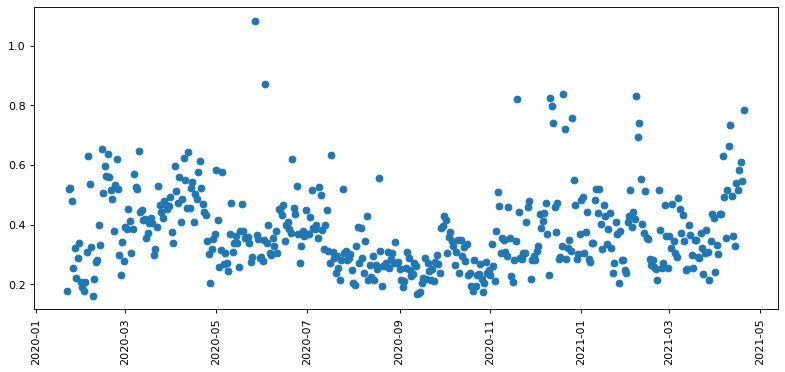

In [118]:
df_train_orign=readDataFromFile(datafile)
df_train_orign = df_train_orign[df_train_orign['INLINE_CT'].notna()]
# target_ToolGID  ='XE_Sorter'
# target_prodID ='D38AL03A'
df_train_orign = df_train_orign.loc[(df_train_orign['TOOLG_ID']==target_ToolGID) &(df_train_orign['PROD_ID']==target_prodID)]
#一嘗資料排除
# df_train_orign = df_train_orign.loc[(df_train_orign['TOOLG_ID']==target_ToolGID) ]
df_train_orign[df_train_orign.MFG_DATE.isin(['20200521','20200525','20200526','20200908','20200907'])]
df_train_orign['MFG_DATE'] = df_train_orign['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_train_orign['INLINE_CT'] =df_train_orign['INLINE_CT'].replace(['0', 0], np.nan)
df_train_orign = df_train_orign[df_train_orign['INLINE_CT'].notna()]
plt.figure(figsize=(12, 5), dpi=80)
plt.plot(df_train_orign['MFG_DATE'], df_train_orign['INLINE_CT'], 'o' )
plt.xticks(rotation=90)
# mean = df_train_orign['INLINE_CT'].mean()

# sd =df_train_orign['INLINE_CT'].std()
# lower =  mean - 2*sd
# if(lower <0):
#     lower=0
# upper = mean + 2*sd
# print( lower,upper)

# 主程式 讀取資料

In [77]:
# 讀取資料

df_train_orign=readDataFromFile(datafile)
df_train_orign = df_train_orign[df_train_orign['INLINE_CT'].notna()]
# target_ToolGID  ='XE_Sorter'
# target_prodID ='D38AL03A'
df_train_orign = df_train_orign.loc[(df_train_orign['TOOLG_ID']==target_ToolGID) &(df_train_orign['PROD_ID']==target_prodID)]
#一嘗資料排除
# df_train_orign = df_train_orign.loc[(df_train_orign['TOOLG_ID']==target_ToolGID) ]
df_train_orign['INLINE_CT'] =df_train_orign['INLINE_CT'].replace(['0', 0], np.nan)
df_train_orign = df_train_orign[df_train_orign['INLINE_CT'].notna()]

mean = df_train_orign['INLINE_CT'].mean()

sd =df_train_orign['INLINE_CT'].std()
lower =  mean - 2*sd
if(lower <0):
    lower=0
upper = mean + 2*sd
print( lower,upper)
 
df_train_orign = df_train_orign[df_train_orign['INLINE_CT'] > lower]   #[x for x in arr if (x > mean - 2 * sd)] 
df_train_orign =  df_train_orign[df_train_orign['INLINE_CT'] < upper] #[x for x in final_list if (x < mean + 2 * sd)] 

df_train_orign['INLINE_CT'].describe()
# EDA(df_train_orign,"INLINE_CT")

# df_train_orign = df_train_orign.drop(columns=['SAMPLING_RATE','CHANGE_RECIPE','BATCH_SIZE','BACKUP_BY_RATE','BACKUP_FOR_RATE',,'SHOT_LOT_RATE','HOLD_RATE_HOURLY','HOLD_RATE_DAILY','C_CLOSE_WIP','RUN_WIP_RATIO_HOURLY','CLOSE_WIP_QTY','WIP_QTY_HOURLY','NO_HOLD_QTY_HOURLY','NO_RWK_MOVE_QTY','PROCESS_JOBTIME','INLINE_CT_BY_WAFER'],axis =1)
df_train_orign = df_train_orign.drop(columns=['TC','PROCESS_TIME','NO_HOLD_WIP_HOURLY','MOVE_QTY','MOVE_QTY_INTERNAL','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','BACKUP_BY_RATE','BACKUP_FOR_RATE','BATCH_SIZE','MOVE_RATIO','MOVE_RATIO_INTERNAL','INLINE_CT_BY_WAFER'],axis =1)
#,'INLINE_CT_BY_LOT','INLINE_CT_BY_WAFER'
#'REWORK_LOT_RATE'


# df_train_orign = df_train_orign.loc[df_train_orign['TOOLG_ID']==target_ToolGID]
#df_train_orign['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
df_train_orign['MFG_DATE'] = df_train_orign['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

df_train = df_train_orign

# df_train =iqrfilter(df_train_orign,'M_NUM',[0.25, 1]) 
# print("iqr 'M_NUM'",df_train.shape)
# df_train =iqrfilter(df_train,'MOVE_QTY',[0.25, 1]) 
# print("iqr 'MOVE'",df_train.shape)
# df_train =iqrfilter(df_train,'NUM_RECIPE',[0.25, 1]) 
# print("iqr 'NUM_RECIPE'",df_train.shape)

#df2_test = df2_test.dropna()# 刪除null值

#刪除columns 值是空的()
df_train = df_train.dropna(axis=1, how='all')

# # # #刪除rows ,target值是空的()
# df_train = df_train[df_train['INLINE_CT'].notna()]

#刪除不合理的 0值
# df_train['EQP_AVAIL_RATE'] = df_train['EQP_AVAIL_RATE'].replace(['0', 0], np.nan)
# df_train = df_train[df_train['EQP_AVAIL_RATE'].notna()]

#check  null 結果
df_train.info()
df_train.isnull().sum()
df_train = df_train.dropna()# 刪除null值
df_train.info()
df_train.isnull().sum()
# # 檢查資料處理  value  是不是有 無限大 
# # # # np.isnan(y.any()) #and gets False
# # # # np.isfinite(y.all()) #and gets True
# # print(np.all(np.isfinite(x)))
# # print(np.all(np.isfinite(y)))

#刪除outliner
df_train =iqrfilter(df_train,'M_NUM',[0.25, 1])

0.107769403240012 0.6397275919963796
<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 18380 to 19230
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MFG_DATE              435 non-null    datetime64[ns]
 1   TOOLG_ID              435 non-null    object        
 2   PROD_ID               435 non-null    object        
 3   IS_HOLIDAY            435 non-null    float64       
 4   M_NUM                 435 non-null    float64       
 5   UP_TIME               435 non-null    float64       
 6   C_UP_TIME             435 non-null    float64       
 7   LOT_SIZE              435 non-null    float64       
 8   C_LOT_SIZE            435 non-null    float64       
 9   EQP_UTIL              435 non-null    float64       
 10  C_EQP_UTIL            435 non-null    float64       
 11  EQP_AVAIL_RATE        435 non-null    float64       
 12  PROCESS_JOBTIME       435 non-null 

## 資料分析 Tool

In [78]:

df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
# e

# df_train1 =iqrfilter(df_train1,'M_NUM',[0.25, 1]) 
# df_train1['MFG_DATE'].max()


# 模型 訓練

In [79]:
# EDA(df_train1,'TRCT')

In [80]:

df_train1.columns

Index(['MFG_DATE', 'TOOLG_ID', 'PROD_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME',
       'C_UP_TIME', 'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL',
       'EQP_AVAIL_RATE', 'PROCESS_JOBTIME', 'INLINE_CT', 'WIP_QTY',
       'NO_HOLD_WIP', 'WIP_QTY_HOURLY', 'RUN_WIP_RATIO',
       'RUN_WIP_RATIO_HOURLY', 'CLOSE_WIP_QTY', 'C_TC', 'C_CLOSE_WIP',
       'HOLD_RATE_01', 'HOLD_RATE_HOURLY', 'HOLD_RATE', 'ENG_LOT_RATE',
       'SHOT_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QLIMIT_RATE',
       'SAMPLING_RATE', 'NUM_RECIPE', 'CHANGE_RECIPE'],
      dtype='object')

# 推估當天 28天 df_sum28

In [81]:
def getsum28(df_train,final_date):
    
    test = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
    print(test['MFG_DATE'].max())
    df = test.groupby(['TOOLG_ID','PROD_ID']).apply(lambda x: x.set_index('MFG_DATE').resample('1D').first())
    num_cols=['M_NUM', 'UP_TIME','C_UP_TIME', 'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL','EQP_AVAIL_RATE', 'PROCESS_JOBTIME', 'INLINE_CT', 'WIP_QTY','NO_HOLD_WIP', 'WIP_QTY_HOURLY', 'RUN_WIP_RATIO','RUN_WIP_RATIO_HOURLY', 'CLOSE_WIP_QTY', 'C_TC', 'C_CLOSE_WIP','HOLD_RATE_01', 'HOLD_RATE_HOURLY', 'HOLD_RATE', 'ENG_LOT_RATE','SHOT_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QLIMIT_RATE','SAMPLING_RATE', 'NUM_RECIPE', 'CHANGE_RECIPE']

    df_sum28 = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean()).reset_index()

    #df_train1['MFG_DATE'].max()
    df_sum28['MFG_DATE'].max()
    #抓最後一天的數據 來預測當天的值 df_test_today
    df_test_today=df_sum28.loc[df_sum28['MFG_DATE']==df_sum28['MFG_DATE'].max()]

    real_data_cols_withkeys =['MFG_DATE','TOOLG_ID','PROD_ID','C_LOT_SIZE','LOT_SIZE','WIP_QTY','HOLD_RATE_01','ENG_LOT_RATE','HOT_LOT_RATE','QLIMIT_RATE','IS_HOLIDAY','INLINE_CT']
    real_data_cols =['C_LOT_SIZE','LOT_SIZE','WIP_QTY','HOLD_RATE_01','ENG_LOT_RATE','HOT_LOT_RATE','QLIMIT_RATE','IS_HOLIDAY','INLINE_CT']
    df_map_today = df_train[real_data_cols_withkeys] 
    df_map_today=df_map_today.loc[df_map_today['MFG_DATE']==df_test_today['MFG_DATE'].max()]

    for index, row in df_test_today.iterrows():
        r = df_map_today[real_data_cols].loc[(df_map_today['MFG_DATE']==row['MFG_DATE'])  & (df_map_today['TOOLG_ID']==row['TOOLG_ID']) &                       (df_map_today['PROD_ID']==row['PROD_ID'])]
        if(r.any(axis=None)):
            for col in real_data_cols:
                df_test_today.loc[index,col]  =r[col].values
        else:
            df_test_today.drop(index, inplace=True)
    
#測試集的答案 驗證用
# #df_test_today['TRCT']= df_test_today['NO_HOLD_QTY']/df_test_today['MOVE_QTY']
# df_test_today['TRCT']= df_test_today['MOVE_QTY']
    return df_test_today

In [82]:
# df_train.to_csv('./data/data_train.csv')
# num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
# df_train.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first()).groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).max()).reset_index().to_csv('./data/data_train28.csv')

# df_train['MFG_DATE'].iloc[0]


In [83]:
# df_train['MFG_DATE'].astype(str).to_numpy() +'_'+np.arange(df_train.shape[0]).astype(str)

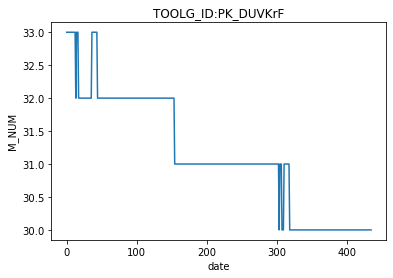

In [84]:
plt.title('TOOLG_ID:'+ df_train['TOOLG_ID'].iloc[0])

plt.ylabel("M_NUM")
plt.xlabel("date")
#t =df_train['MFG_DATE'].astype(str).to_numpy() +'_'+np.arange(df_train.shape[0]).astype(str)
t =np.arange(df_train.shape[0])
plt.plot(t, df_train['M_NUM'])
# plt.savefig('./'+df['TOOLG_ID'].iloc[0]+'.pdf',width=600, height=350)
plt.show()


# 計算測試集資料 取28天平均 df

In [85]:
# df = pd.DataFrame(columns = df_train.columns)

# # for i in range(1,15):
# for i in range(1,((df_train['MFG_DATE'].max()- datetime.datetime.strptime(final_date, "%Y-%m-%d")).days)+2 ):
#     _final_date =   datetime.datetime.strptime(final_date, "%Y-%m-%d")+ datetime.timedelta(days=i)
 
#     _df = getsum28(df_train,_final_date)
#     df = df.append(_df,ignore_index=True)
    
# # print(df.shape)
# # print(df.describe())

# df.to_csv('./data/getsum28.csv')

# df_test_real 實際值 抓 real 

In [86]:
df_train['MFG_DATE'].max()

Timestamp('2021-04-19 00:00:00')

In [87]:

df_test_real =  df_train[df_train['MFG_DATE'] >=  pd.to_datetime(final_date)]


# def :計算準確率 accsum

In [88]:
def accsum(def_result,target_col ='INLINE_CT'):
    _accsum=0
    def_result[def_result['INLINE_CT'] ==0.0][target_col]  =0.0001
    def_result[def_result['predict'] <0]['predict']  =0
    for index,row in def_result.iterrows():
        if row[target_col] <0 :
            row[target_col]  =0.00001
        if row[target_col] ==0.0:
            row[target_col]  =0.00001
        # print(row['TRCT'] )
        if 1- abs((row['predict'] - row[target_col])/row[target_col] ) >0 :
            
            _accsum+=(1- abs((row['predict'] - row[target_col])/row[target_col] ))
    
    return _accsum/def_result.shape[0]

# 訓練並測試模型( 每日歷史資料 訓練)

##  1. 每日歷史資料(df_train1) 跑 LR


In [89]:
df_train1

,MFG_DATE,TOOLG_ID,PROD_ID,IS_HOLIDAY,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,...,HOLD_RATE_HOURLY,HOLD_RATE,ENG_LOT_RATE,SHOT_LOT_RATE,HOT_LOT_RATE,REWORK_LOT_RATE,QLIMIT_RATE,SAMPLING_RATE,NUM_RECIPE,CHANGE_RECIPE
18488,2020-12-30,PK_DUVKrF,C11MD01A,0.9613,32.0,0.917776,0.139989,22.609467,0.339840,0.963044,...,0.052772,0.050217,0.000000,0.000000,0.000000,0.004973,0.366920,0.0,22.0,0.538462
18489,2020-12-31,PK_DUVKrF,C11MD01A,0.9613,32.0,0.958782,0.133993,23.550847,0.326304,0.953438,...,0.040184,0.040532,0.002879,0.000000,0.002879,0.015473,0.596977,0.0,19.0,0.491525
18490,2020-12-29,PK_DUVKrF,C11MD01A,0.9613,32.0,0.932197,0.137784,24.277457,0.316470,0.962500,...,0.053429,0.054784,0.000000,0.000000,0.000000,0.006190,0.487619,0.0,20.0,0.520231
18491,2020-12-28,PK_DUVKrF,C11MD01A,0.9613,32.0,0.933522,0.137629,24.335443,0.315693,0.976044,...,0.037486,0.036943,0.002081,0.000000,0.002081,0.063459,0.410663,0.0,20.0,0.506329
18492,2020-12-27,PK_DUVKrF,C11MD01A,1.0000,32.0,0.979034,0.131313,23.645833,0.324879,0.980770,...,0.041149,0.040403,0.002056,0.000000,0.000000,0.097504,0.335683,0.0,20.0,0.569444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19226,2020-03-25,PK_DUVKrF,C11MD01A,0.9613,30.0,0.927887,0.127001,23.072626,0.326755,0.985275,...,0.027468,0.023908,0.000000,0.004358,0.000000,0.000726,0.060533,0.0,28.0,0.463687
19227,2020-03-24,PK_DUVKrF,C11MD01A,0.9613,30.0,0.923975,0.127778,23.855072,0.315910,0.980481,...,0.017886,0.016168,0.001823,0.001823,0.000000,0.015796,0.022783,0.0,29.0,0.507246
19228,2020-03-26,PK_DUVKrF,C11MD01A,0.9613,30.0,0.940823,0.125269,23.216216,0.324990,0.966410,...,0.037203,0.036951,0.001746,0.010477,0.000000,0.008149,0.014552,0.0,27.0,0.459459
19229,2020-03-23,PK_DUVKrF,C11MD01A,0.9613,30.0,0.931506,0.126559,23.209040,0.324576,0.978891,...,0.024657,0.024508,0.004382,0.011685,0.000000,0.088121,0.079114,0.0,28.0,0.367232


In [90]:
df_test_real.shape

(104, 33)

In [91]:
df_test_real

,MFG_DATE,TOOLG_ID,PROD_ID,IS_HOLIDAY,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,...,HOLD_RATE_HOURLY,HOLD_RATE,ENG_LOT_RATE,SHOT_LOT_RATE,HOT_LOT_RATE,REWORK_LOT_RATE,QLIMIT_RATE,SAMPLING_RATE,NUM_RECIPE,CHANGE_RECIPE
18380,2021-04-09,PK_DUVKrF,C11MD01A,0.9613,33.0,0.957753,0.132199,22.519231,0.339393,0.977224,...,0.016231,0.015675,0.009109,0.0,0.00000,0.030743,0.256476,0.0,21.0,0.493590
18381,2021-04-08,PK_DUVKrF,C11MD01A,0.9613,33.0,0.946089,0.133852,23.346821,0.327383,0.977318,...,0.031470,0.030420,0.001486,0.0,0.00000,0.038128,0.205249,0.0,20.0,0.554913
18382,2021-04-07,PK_DUVKrF,C11MD01A,0.9613,33.0,0.910848,0.139011,22.936416,0.333263,0.975401,...,0.027125,0.026706,0.004788,0.0,0.00000,0.021421,0.296371,0.0,21.0,0.462428
18383,2021-04-05,PK_DUVKrF,C11MD01A,1.0000,33.0,0.936376,0.135177,23.551887,0.324608,0.985143,...,0.012233,0.012192,0.004606,0.0,0.00000,0.015422,0.310835,0.0,21.0,0.448113
18384,2021-04-06,PK_DUVKrF,C11MD01A,0.9613,33.0,0.922182,0.137260,23.453552,0.325941,0.981781,...,0.014188,0.014334,0.004427,0.0,0.00000,0.012349,0.360438,0.0,21.0,0.393443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18483,2021-01-06,PK_DUVKrF,C11MD01A,0.9613,32.0,0.946069,0.135583,23.194175,0.331311,0.969235,...,0.038654,0.037495,0.000628,0.0,0.00000,0.014860,0.404144,0.0,22.0,0.529126
18484,2021-01-04,PK_DUVKrF,C11MD01A,0.9613,32.0,0.939644,0.136423,24.780899,0.310077,0.984334,...,0.063797,0.062328,0.000000,0.0,0.00000,0.022897,0.473362,0.0,21.0,0.471910
18485,2021-01-01,PK_DUVKrF,C11MD01A,1.0000,32.0,0.975648,0.131629,24.517241,0.313448,0.965060,...,0.040837,0.040130,0.002250,0.0,0.00225,0.029817,0.514487,0.0,21.0,0.524138
18486,2021-01-03,PK_DUVKrF,C11MD01A,1.0000,32.0,0.985784,0.130108,23.982759,0.320399,0.972542,...,0.040940,0.040415,0.000479,0.0,0.00000,0.089863,0.418644,0.0,21.0,0.580460


r2: 0.530698721983271
MAE: 0.03983015650064348
MSE: 0.0031361008782298553
RMSE: 0.056000900691237594
intercept_ : [0.57213714]
r2: 0.6789011126377102
train acc%: 0.8696164403136732
r2: 0.5994023507884965
real acc%: 0.866024283327228


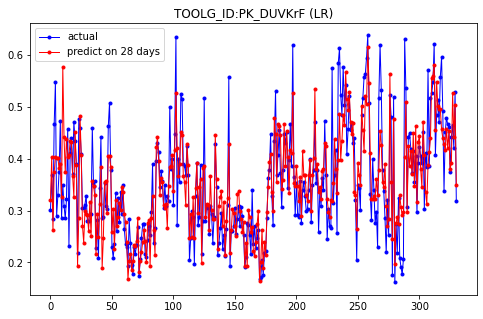

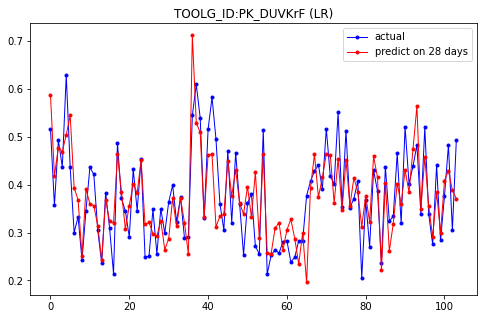

In [92]:
# trainLR(df_train)
#計算準確率分數
trainLR(df_train1)
def_result = testLR(df_train1)
print("train acc%:",accsum(def_result))

# #計算準確率分數
# def_result = testLR(df,df_test_real)

# print("test acc%:",accsum(def_result))

#計算準確率分數
def_result= testLR(df_test_real)
print("real acc%:",accsum(def_result))




## 2.每日歷史資料 跑 XGBoost


In [93]:
df_test_real

,MFG_DATE,TOOLG_ID,PROD_ID,IS_HOLIDAY,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,...,HOLD_RATE_HOURLY,HOLD_RATE,ENG_LOT_RATE,SHOT_LOT_RATE,HOT_LOT_RATE,REWORK_LOT_RATE,QLIMIT_RATE,SAMPLING_RATE,NUM_RECIPE,CHANGE_RECIPE
18380,2021-04-09,PK_DUVKrF,C11MD01A,0.9613,33.0,0.957753,0.132199,22.519231,0.339393,0.977224,...,0.016231,0.015675,0.009109,0.0,0.00000,0.030743,0.256476,0.0,21.0,0.493590
18381,2021-04-08,PK_DUVKrF,C11MD01A,0.9613,33.0,0.946089,0.133852,23.346821,0.327383,0.977318,...,0.031470,0.030420,0.001486,0.0,0.00000,0.038128,0.205249,0.0,20.0,0.554913
18382,2021-04-07,PK_DUVKrF,C11MD01A,0.9613,33.0,0.910848,0.139011,22.936416,0.333263,0.975401,...,0.027125,0.026706,0.004788,0.0,0.00000,0.021421,0.296371,0.0,21.0,0.462428
18383,2021-04-05,PK_DUVKrF,C11MD01A,1.0000,33.0,0.936376,0.135177,23.551887,0.324608,0.985143,...,0.012233,0.012192,0.004606,0.0,0.00000,0.015422,0.310835,0.0,21.0,0.448113
18384,2021-04-06,PK_DUVKrF,C11MD01A,0.9613,33.0,0.922182,0.137260,23.453552,0.325941,0.981781,...,0.014188,0.014334,0.004427,0.0,0.00000,0.012349,0.360438,0.0,21.0,0.393443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18483,2021-01-06,PK_DUVKrF,C11MD01A,0.9613,32.0,0.946069,0.135583,23.194175,0.331311,0.969235,...,0.038654,0.037495,0.000628,0.0,0.00000,0.014860,0.404144,0.0,22.0,0.529126
18484,2021-01-04,PK_DUVKrF,C11MD01A,0.9613,32.0,0.939644,0.136423,24.780899,0.310077,0.984334,...,0.063797,0.062328,0.000000,0.0,0.00000,0.022897,0.473362,0.0,21.0,0.471910
18485,2021-01-01,PK_DUVKrF,C11MD01A,1.0000,32.0,0.975648,0.131629,24.517241,0.313448,0.965060,...,0.040837,0.040130,0.002250,0.0,0.00225,0.029817,0.514487,0.0,21.0,0.524138
18486,2021-01-03,PK_DUVKrF,C11MD01A,1.0000,32.0,0.985784,0.130108,23.982759,0.320399,0.972542,...,0.040940,0.040415,0.000479,0.0,0.00000,0.089863,0.418644,0.0,21.0,0.580460


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   36.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  1.1min finished
test 得分:0.5111850800093048
引數的最佳取值：{'max_depth': 13, 'min_child_weight': 3, 'n_estimators': 200}
最佳模型得分:0.65953734313052
cv_results_ {'mean_fit_time': array([0.65219965, 0.83999839, 0.67059689, 0.69359956, 1.09519978,
       4.34131551, 3.99931917, 1.1685976 , 0.69559994, 0.4335989 ,
       0.57319894, 0.69399915, 0.47119884, 0.51099868, 0.54179935,
       0.58519845, 0.62499738, 2.65645127, 2.04859896, 1.03019609,
       0.91459799, 0.95139866, 1.07980218, 1.67159643, 0.66399636,
       0.61999903, 0.80760069, 0.78779669, 0.81819544, 0.84779606,
       0.66400003, 0.82399821, 0.90459986, 0.87279844, 0.94319921,
       0.8837986 ]), 'std_fit_time': array([0.12933869, 0.16078417, 0.03455158, 0.05736423, 0.369407  ,
       1

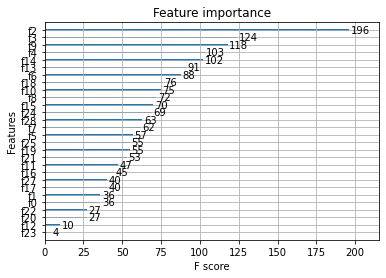

r2: 0.8913858945238163
Train acc%: 0.9592493002054738
r2: 0.5238779504473003
real acc%: 0.8657775674044336


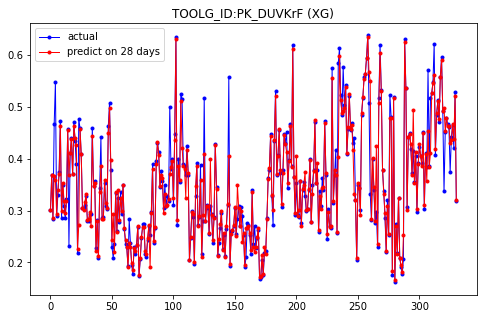

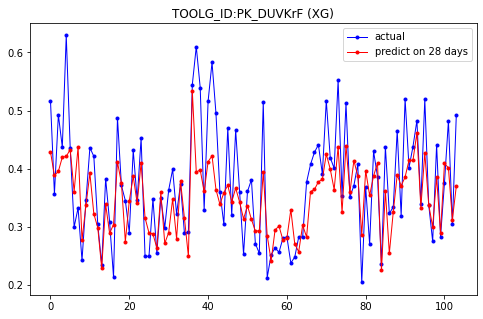

In [94]:
#驗證訓練集 train
trainXG(df_train1)
def_result = testXG(df_train1)
# print(sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("Train acc%:",accsum(def_result)) 
# #驗證測試集  test
# def_result = testXG(df,df)
# # print(sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
# print("Train acc%:",accsum(def_result)) 

def_result= testXG(df_test_real)
print("real acc%:",accsum(def_result))


In [95]:
df_train1.columns

Index(['MFG_DATE', 'TOOLG_ID', 'PROD_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME',
       'C_UP_TIME', 'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL',
       'EQP_AVAIL_RATE', 'PROCESS_JOBTIME', 'INLINE_CT', 'WIP_QTY',
       'NO_HOLD_WIP', 'WIP_QTY_HOURLY', 'RUN_WIP_RATIO',
       'RUN_WIP_RATIO_HOURLY', 'CLOSE_WIP_QTY', 'C_TC', 'C_CLOSE_WIP',
       'HOLD_RATE_01', 'HOLD_RATE_HOURLY', 'HOLD_RATE', 'ENG_LOT_RATE',
       'SHOT_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QLIMIT_RATE',
       'SAMPLING_RATE', 'NUM_RECIPE', 'CHANGE_RECIPE'],
      dtype='object')

## 3.每日歷史資料 跑 NN

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


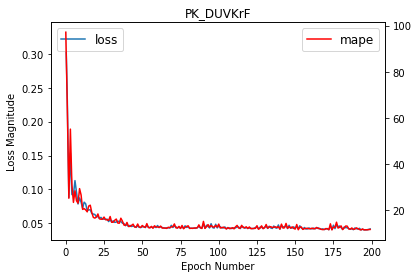

Train acc%: 0.8856338438223851
real acc%: 0.866822822109931


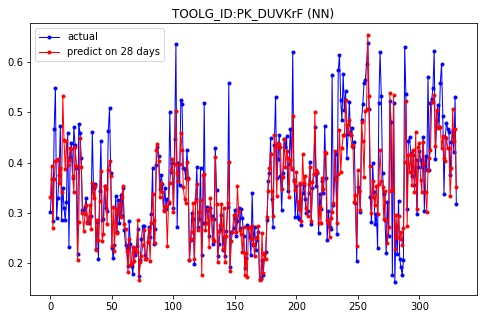

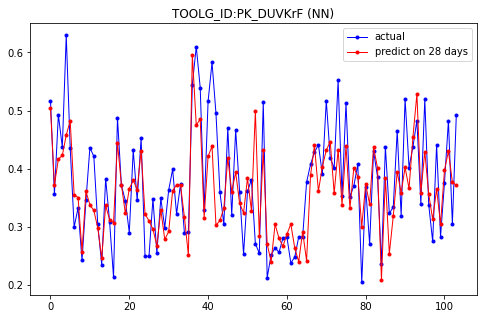

In [96]:
trainNN(df_train1)
def_result = testNN(df_train1)
print("Train acc%:",accsum(def_result)) 


# def_result = testNN(df,df_test_real)
# print("test acc%:",accsum(def_result)) 


def_result= testNN(df_test_real)
print("real acc%:",accsum(def_result))

# 3.每日歷史資料 跑 Cat

arn: 0.0189128	total: 877ms	remaining: 1.19s
127:	learn: 0.0187821	total: 883ms	remaining: 1.19s
128:	learn: 0.0185173	total: 890ms	remaining: 1.18s
129:	learn: 0.0183829	total: 896ms	remaining: 1.17s
130:	learn: 0.0181457	total: 901ms	remaining: 1.16s
131:	learn: 0.0180497	total: 907ms	remaining: 1.15s
132:	learn: 0.0178520	total: 912ms	remaining: 1.15s
133:	learn: 0.0177382	total: 920ms	remaining: 1.14s
134:	learn: 0.0176859	total: 924ms	remaining: 1.13s
135:	learn: 0.0174533	total: 929ms	remaining: 1.12s
136:	learn: 0.0173178	total: 935ms	remaining: 1.11s
137:	learn: 0.0170745	total: 938ms	remaining: 1.1s
138:	learn: 0.0168375	total: 943ms	remaining: 1.09s
139:	learn: 0.0167241	total: 951ms	remaining: 1.09s
140:	learn: 0.0166834	total: 954ms	remaining: 1.08s
141:	learn: 0.0164761	total: 959ms	remaining: 1.07s
142:	learn: 0.0163582	total: 966ms	remaining: 1.06s
143:	learn: 0.0161880	total: 971ms	remaining: 1.05s
144:	learn: 0.0161381	total: 976ms	remaining: 1.04s
145:	learn: 0.015963

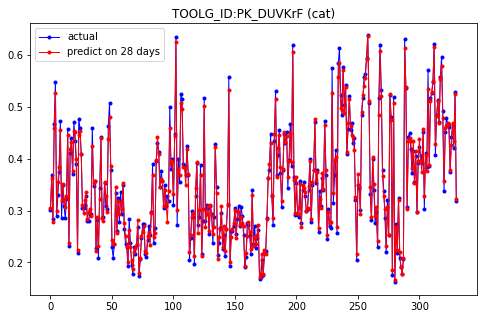

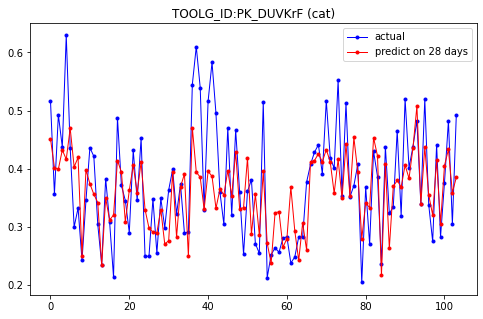

In [97]:
trainCat(df_train1)
def_result = testCat(df_train1)
# sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]
print("Train acc%:",accsum(def_result)) 

# def_result = testCat(df,df_test_real)
# # sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]
# print("test acc%:",accsum(def_result)) 


def_result= testCat(df_test_real)
print("real acc%:",accsum(def_result))

In [98]:
# df_test_real.to_csv("./data/df_test_real.csv")
# df_train_sum28_1.to_csv('./data/df_train_sum28_1.csv')
# df.to_csv('./data/df.csv')

In [99]:
df_train.columns


Index(['MFG_DATE', 'TOOLG_ID', 'PROD_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME',
       'C_UP_TIME', 'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL',
       'EQP_AVAIL_RATE', 'PROCESS_JOBTIME', 'INLINE_CT', 'WIP_QTY',
       'NO_HOLD_WIP', 'WIP_QTY_HOURLY', 'RUN_WIP_RATIO',
       'RUN_WIP_RATIO_HOURLY', 'CLOSE_WIP_QTY', 'C_TC', 'C_CLOSE_WIP',
       'HOLD_RATE_01', 'HOLD_RATE_HOURLY', 'HOLD_RATE', 'ENG_LOT_RATE',
       'SHOT_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QLIMIT_RATE',
       'SAMPLING_RATE', 'NUM_RECIPE', 'CHANGE_RECIPE'],
      dtype='object')

In [100]:
def PCA(df):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化
    from sklearn.model_selection import train_test_split
    X,Y = preHandleDat(df,False)
    
    #拆分train validation set
    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.3, random_state=587)
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)
    # standardize the feature 標準化單位方差
    sc = StandardScaler()
    df_pca = df.copy(deep=False)
    x_train_std = sc.fit_transform(df_pca.drop(['MFG_DATE','TOOLG_ID'],axis=1))
    # x_test_std = sc.fit_transform(x_test)
    # print(x_train_std)
 
    # 構造協方差矩陣，得到特徵向量和特徵值
    cov_matrix = np.cov(x_train_std.T)
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix)
    # print("values\n ", eigen_val, "\nvector\n ", eigen_vec)
 
    # 解釋方差比
    tot = sum(eigen_val)  # 總特徵值和
    var_exp = [(i / tot) for i in sorted(eigen_val, reverse=True)]  # 計算解釋方差比，降序
    # print(var_exp)
    # cum_var_exp = np.cumsum(var_exp)  # 累加方差比率
    # plt.rcParams['font.sans-serif'] = ['SimHei']  # 顯示中文
    # plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='獨立解釋方差')  # 柱狀 Individual_explained_variance
    # plt.step(range(1, 14), cum_var_exp, where='mid', label='累加解釋方差')  # Cumulative_explained_variance
    # plt.ylabel("解釋方差率")
    # plt.xl         ZAabel("主成分索引")
    # plt.legend(loc='right')
    # plt.show()

    # 特徵變換
    eigen_pairs = [(np.abs(eigen_val[i]), eigen_vec[:, i]) for i in range(len(eigen_val))]
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)  # (特徵值，特徵向量)降序排列
    # print(eigen_pairs)
    w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))  # 降維投影矩陣W
    # print(w)
    x_train_pca = x_train_std.dot(w)
    # print(x_train_pca)
    color = ['r', 'g', 'b']
    marker = ['s', 'x', 'o']
    # for l, c, m in zip(np.unique(y_train), color, marker):
    #     plt.scatter(x_train_pca[y_train == l, 0],
    #                 x_train_pca[y_train == l, 1],
    #                 c=c, label=l, marker=m)
    # plt.title('Result')
    # plt.xlabel('PC1')
    # plt.ylabel('PC2')
    # plt.legend(loc='lower left')
    # plt.show()

In [101]:
# PCA(df_train1)

In [102]:
# def NNTunning():
 
#     from tensorflow.python.ops import summary_ops_v2
#     from tensorflow.python.keras.backend import get_graph
#     #hparam tunning
#     HP_NUM_UNITS_ONE = hp.HParam('num_units_one', hp.Discrete([5, 10, 20]))
#     HP_NUM_UNITS_TWO = hp.HParam('num_units_two', hp.Discrete([10, 20, 40]))
#     HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

#     METRIC_ACCURACY = 'accuracy'

#     with tf.summary.create_file_writer(output_dir).as_default():
#     hp.hparams_config(
#         hparams=[HP_NUM_UNITS_ONE, HP_NUM_UNITS_TWO, HP_OPTIMIZER],
#         metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#     )
#     model_dict = {}
#     session_num = 0
#     for num_units_one in HP_NUM_UNITS_ONE.domain.values:
#     for num_units_two in HP_NUM_UNITS_TWO.domain.values:
#         for optimizer in HP_OPTIMIZER.domain.values:     
#         hparams = {
#             HP_NUM_UNITS_ONE: num_units_one,
#             HP_NUM_UNITS_TWO: num_units_two,
#             HP_OPTIMIZER: optimizer,
#         }
#         run_name = "run-%d" % session_num
#         print('>> Starting trial: %s' % run_name)
#         print({h.name: hparams[h] for h in hparams})
#         model, accuracy = run(output_dir + run_name, hparams)
#         model_dict[accuracy] = model
#         session_num += 1

#     best_model = model_dict[max(list(model_dict.keys()))]

In [103]:
# def train_test_NNmodel(hparams):  
#   model = tf.keras.models.Sequential()
#   model.add(layers.Dense(hparams[HP_NUM_UNITS_ONE], activation = 'relu',input_shape=(13,)))
#   model.add(layers.Dense(hparams[HP_NUM_UNITS_TWO],activation = 'relu' ))
#   model.add(layers.Dense(1,activation = 'sigmoid' ))
#   model.compile(
#       optimizer=hparams[HP_OPTIMIZER],
#       loss='binary_crossentropy',
#       metrics=['accuracy'],
#   )

#   model.fit(x_train, y_train, epochs=30) 
#   _, accuracy = model.evaluate(x_test, y_test)
#   return model, accuracy

# def runNN(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     model, accuracy = train_test_model(hparams)
#     tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
#   return model, accuracy

In [104]:
np.linspace(0.0,0.7,8)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [105]:
# #EDA(df_train1,'TRCT')
# feature_config = sv.FeatureConfig(skip=['LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY'
# ],  # 要忽略哪個特徵
#                                 #   force_cat=[ 'LOT_ID', 'STATUS', 'CHIPNAME', 'LAYER','PRIORITY', 'LOT_TYPE',  'WS_DATE','IS_MAIN_ROUTE'], # Categorical特徵
#                                 #   force_num=['WIP_QTY','REMAIN_LAYER_SEQ'], # Numerical特徵
#                                   force_text=None
#                                   ) # Text特徵
# pairwise_analysis = 'on'
# my_report = sv.compare([df_train.fillna(0) , "all Data"], [df_test_real.fillna(0) , "Test Data"],  target_feat="TRCT", feat_cfg=feature_config)
# my_report.show_html(filepath='./sweetvizHTML/df_train.html' ) # 儲存為html的格式

In [106]:
df_train1.columns

Index(['MFG_DATE', 'TOOLG_ID', 'PROD_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME',
       'C_UP_TIME', 'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL',
       'EQP_AVAIL_RATE', 'PROCESS_JOBTIME', 'INLINE_CT', 'WIP_QTY',
       'NO_HOLD_WIP', 'WIP_QTY_HOURLY', 'RUN_WIP_RATIO',
       'RUN_WIP_RATIO_HOURLY', 'CLOSE_WIP_QTY', 'C_TC', 'C_CLOSE_WIP',
       'HOLD_RATE_01', 'HOLD_RATE_HOURLY', 'HOLD_RATE', 'ENG_LOT_RATE',
       'SHOT_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QLIMIT_RATE',
       'SAMPLING_RATE', 'NUM_RECIPE', 'CHANGE_RECIPE'],
      dtype='object')